In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

## Load and Preprocess Data

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

In [4]:
# Only keep samples with current profiles that exceed 1 kA
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

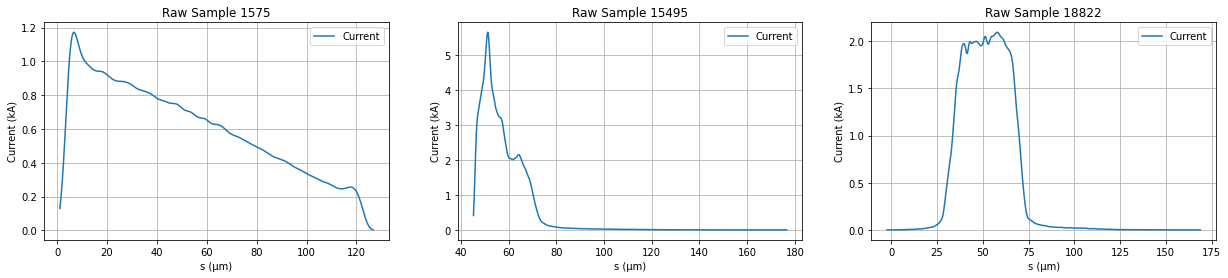

In [42]:
samples = np.random.randint(0, len(filtered), size=3)

plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Raw Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

In [43]:
# Shift center of mass of each current profile onto the origin

def shift_onto_center_of_mass(s, current):
    """Shift a current profile such that its center of mass it at 0."""
    cm = (s * current).sum() / current.sum()
    return s - cm, current

shifted = [shift_onto_center_of_mass(s, current) for s, current in filtered]

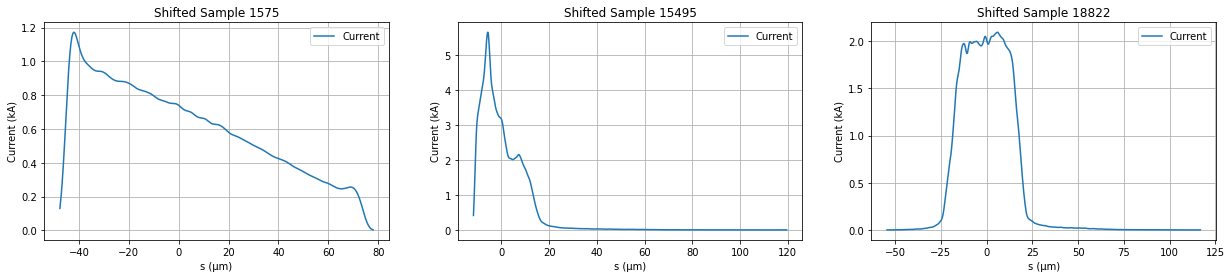

In [44]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    current = shifted[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Shifted Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

In [45]:
# Fit polynomial to each profile

polynomials = [Polynomial.fit(*current, deg=30) for current in shifted]

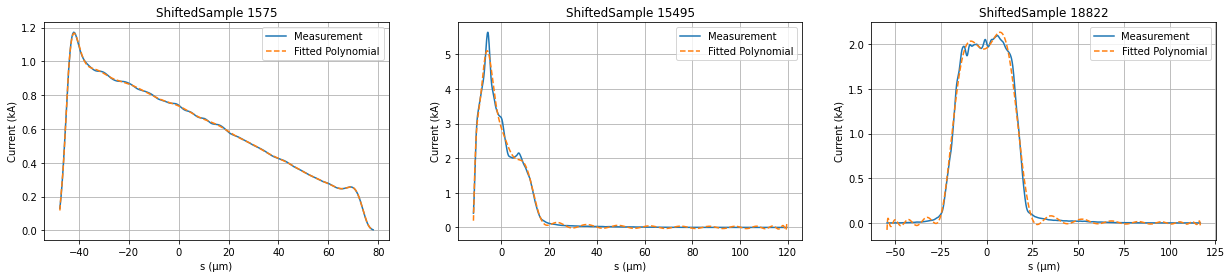

In [46]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    current = shifted[sample][1]
    poly = polynomials[sample]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"ShiftedSample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Measurement")
    plt.plot(s*1e6, poly(s)*1e-3, ls="--", label="Fitted Polynomial")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

In [12]:
# Make formfactors
def current2formfactor(s, current):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set="both")
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = [current2formfactor(*current) for current in shifted]

/usr/local/Caskroom/miniconda/base/envs/spectral-vd/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


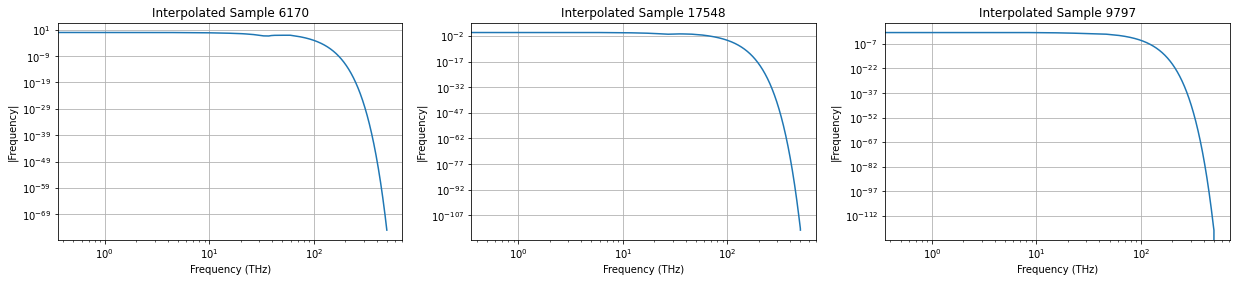

In [13]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    frequency = formfactors[sample][0]
    ff = formfactors[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.loglog(frequency*1e-12, ff, label="Formfactor")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("|Frequency|")
    plt.grid()
plt.show()

## Training

In [14]:
X = np.stack([formfactor for _, formfactor in formfactors])
y = np.stack([poly.coef for poly in polynomials])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [16]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)

In [17]:
model = keras.Sequential([
    layers.Dense(200, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(50, activation="relu"),
    layers.Dense(y_train.shape[1], activation="relu")]
)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

2021-10-17 18:14:41.330584: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=300, batch_size=64, validation_split=0.25, verbose=0)

2021-10-17 18:14:42.750807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


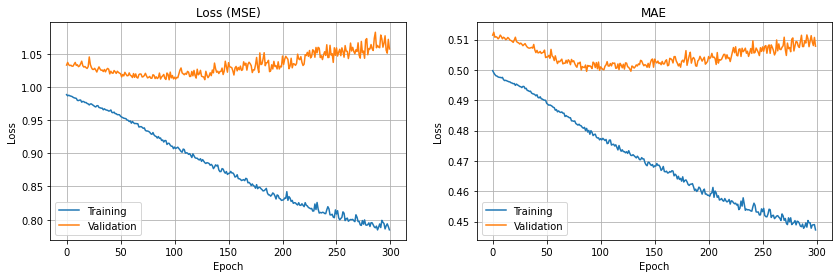

In [19]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.subplot(122)
plt.title("MAE")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [20]:
# Evaluate

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)

64/64 [==============================] - 0s 2ms/step - loss: 1.0054 - mae: 0.4945


## Test

In [47]:
X_samples = X[samples]
y_samples = y[samples]

In [48]:
X_samples_scaled = X_scaler.transform(X_samples)
y_predict_scaled = model.predict(X_samples_scaled)
y_predict = y_scaler.inverse_transform(y_predict_scaled)

In [53]:
Polynomial(y_samples[i]).coef

array([ 3.26189125e+01,  1.71922142e+03, -4.00691867e+03, -3.35985056e+05,
        1.78721081e+06,  7.47015788e+06, -4.91598906e+07, -8.83614422e+07,
        6.55016126e+08,  6.87211362e+08, -5.32660133e+09, -3.83891004e+09,
        2.90789732e+10,  1.58519957e+10, -1.11875800e+11, -4.83761000e+10,
        3.10975351e+11,  1.08176765e+11, -6.30970652e+11, -1.75303270e+11,
        9.33610424e+11,  2.02538829e+11, -9.94954122e+11, -1.62178322e+11,
        7.42837351e+11,  8.53949451e+10, -3.68359030e+11, -2.65729985e+10,
        1.08890063e+11,  3.70107981e+09, -1.45135969e+10])

In [54]:
polynomials[samples[i]].coef

array([ 3.26189125e+01,  1.71922142e+03, -4.00691867e+03, -3.35985056e+05,
        1.78721081e+06,  7.47015788e+06, -4.91598906e+07, -8.83614422e+07,
        6.55016126e+08,  6.87211362e+08, -5.32660133e+09, -3.83891004e+09,
        2.90789732e+10,  1.58519957e+10, -1.11875800e+11, -4.83761000e+10,
        3.10975351e+11,  1.08176765e+11, -6.30970652e+11, -1.75303270e+11,
        9.33610424e+11,  2.02538829e+11, -9.94954122e+11, -1.62178322e+11,
        7.42837351e+11,  8.53949451e+10, -3.68359030e+11, -2.65729985e+10,
        1.08890063e+11,  3.70107981e+09, -1.45135969e+10])

-----
True
poly([ 6.26841408e+02 -4.50981675e+02 -1.54428985e+03 -2.33300888e+03
  8.34742698e+04  6.41485832e+04 -2.00184575e+06 -9.50974357e+05
  2.61536007e+07  9.47293272e+06 -2.12519572e+08 -6.59292120e+07
  1.15905272e+09  3.22458053e+08 -4.43705999e+09 -1.11885582e+09
  1.22322491e+10  2.78193905e+09 -2.45847716e+10 -4.97379567e+09
  3.60610936e+10  6.34185548e+09 -3.81910900e+10 -5.62341540e+09
  2.84415915e+10  3.29064656e+09 -1.41324872e+10 -1.14044208e+09
  4.20744337e+09  1.76955654e+08 -5.67736277e+08])
poly([ 6.26841408e+02 -4.50981675e+02 -1.54428985e+03 -2.33300888e+03
  8.34742698e+04  6.41485832e+04 -2.00184575e+06 -9.50974357e+05
  2.61536007e+07  9.47293272e+06 -2.12519572e+08 -6.59292120e+07
  1.15905272e+09  3.22458053e+08 -4.43705999e+09 -1.11885582e+09
  1.22322491e+10  2.78193905e+09 -2.45847716e+10 -4.97379567e+09
  3.60610936e+10  6.34185548e+09 -3.81910900e+10 -5.62341540e+09
  2.84415915e+10  3.29064656e+09 -1.41324872e+10 -1.14044208e+09
  4.20744337e+09  

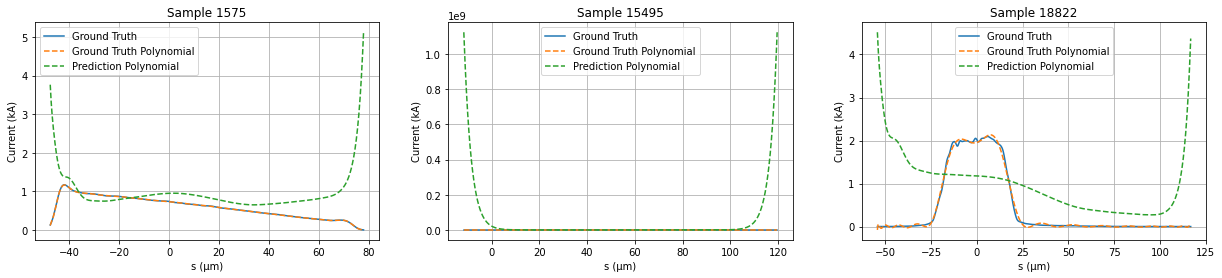

In [71]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    truth = shifted[sample][1]
        
    # s_poly = np.linspace(-200e-6, 200e-6, 1000)
    
    truth_poly = Polynomial(y_samples[i])
    truth_poly2 = polynomials[samples[i]]
    prediction = Polynomial(y_predict[i])
    
    print("-----")
    print(all(truth_poly.coef == truth_poly.coef))
    print(truth_poly)
    print(truth_poly2)
    
    print(truth_poly.domain)
    print(truth_poly2.domain)
    
    truth_poly.domain = truth_poly2.domain
    prediction.domain = truth_poly2.domain
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample}")
    plt.plot(s*1e6, truth*1e-3, label="Ground Truth")
    plt.plot(s*1e6, truth_poly(s)*1e-3, ls="--", label="Ground Truth Polynomial")
    # plt.plot(s*1e6, truth_poly2(s)*1e-3, ls="--", label="Ground Truth Polynomial 2")
    plt.plot(s*1e6, prediction(s)*1e-3, ls="--", label="Prediction Polynomial")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()